In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from graphxai.datasets import ShapeGGen
from graphxai.explainers import GradExplainer, GNNExplainer, PGMExplainer
from graphxai.metrics.base import graph_exp_acc, graph_exp_faith, graph_exp_stability
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

c:\Users\Lingg\miniconda3\envs\graphxai_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Generate dataset ShapeGGen
dataset = ShapeGGen(model_layers=3, num_graphs=1, make_explanations=True)
# Ambil graph dari dataset
data = dataset.graph  # Dataset hanya memiliki satu graf
explanation = dataset.explanations  # atau mungkin dataset.explanations jika atributnya berbentuk list

print(f"Graph Data: {data}")
print(f"Graph Explanations: {explanation}")
print(f"Explanation Available: {'Yes' if explanation is not None else 'No'}")

100%|██████████| 45/45 [00:00<00:00, 297.43it/s]


Graph Data: Data(x=[135, 11], edge_index=[2, 380], y=[135], shape=[135])
Graph Explanations: [[<graphxai.utils.explanation.Explanation object at 0x000001F6ABC38E20>], [<graphxai.utils.explanation.Explanation object at 0x000001F6ABC387C0>], [<graphxai.utils.explanation.Explanation object at 0x000001F6ABC38C40>], [<graphxai.utils.explanation.Explanation object at 0x000001F6ABC38D60>], [<graphxai.utils.explanation.Explanation object at 0x000001F6ABC38CA0>], [<graphxai.utils.explanation.Explanation object at 0x000001F6ABC38E80>], [<graphxai.utils.explanation.Explanation object at 0x000001F691A3E880>], [<graphxai.utils.explanation.Explanation object at 0x000001F691A3E160>], [<graphxai.utils.explanation.Explanation object at 0x000001F691A3E520>], [<graphxai.utils.explanation.Explanation object at 0x000001F6ABC82BE0>], [<graphxai.utils.explanation.Explanation object at 0x000001F6ABC82B80>], [<graphxai.utils.explanation.Explanation object at 0x000001F6ABC82BB0>], [<graphxai.utils.explanation.E

In [30]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

#  Model training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(torch.unique(data.y))  # Get number of unique classes from labels
model = GCN(data.x.shape[1], 16, num_classes).to(device)

# Create train mask (for example, using 80% of nodes for training)
num_nodes = data.x.size(0)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_indices = torch.randperm(num_nodes)[:int(0.8 * num_nodes)]
train_mask[train_indices] = True
data.train_mask = train_mask

data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(500):
    loss = train()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

Epoch 0, Loss: 0.6699
Epoch 20, Loss: 0.5080
Epoch 40, Loss: 0.4338
Epoch 60, Loss: 0.3969
Epoch 80, Loss: 0.3706
Epoch 100, Loss: 0.3489
Epoch 120, Loss: 0.3301
Epoch 140, Loss: 0.3115
Epoch 160, Loss: 0.2900
Epoch 180, Loss: 0.2694
Epoch 200, Loss: 0.2496
Epoch 220, Loss: 0.2312
Epoch 240, Loss: 0.2136
Epoch 260, Loss: 0.1969
Epoch 280, Loss: 0.1813
Epoch 300, Loss: 0.1666
Epoch 320, Loss: 0.1530
Epoch 340, Loss: 0.1404
Epoch 360, Loss: 0.1287
Epoch 380, Loss: 0.1183
Epoch 400, Loss: 0.1088
Epoch 420, Loss: 0.1001
Epoch 440, Loss: 0.0922
Epoch 460, Loss: 0.0847
Epoch 480, Loss: 0.0778


In [31]:
# Inisialisasi explainer
grad_explainer = GradExplainer(model,criterion=F.nll_loss)
gnn_explainer = GNNExplainer(model)
pgm_explainer = PGMExplainer(model, explain_graph=False)

# Ambil satu node untuk dijelaskan
node_idx = 10  # Pilih node yang ada dalam train set
x, edge_index = data.x, data.edge_index

node_id = node_idx.item() if isinstance(node_idx, torch.Tensor) else node_idx


grad_explanation = grad_explainer.get_explanation_node(node_idx=node_idx, x=x, edge_index=edge_index)
gnn_explanation = gnn_explainer.get_explanation_node(node_idx=node_idx, x=x, edge_index=edge_index)
pgm_explanation = pgm_explainer.get_explanation_node(node_idx=node_idx, x=x, edge_index=edge_index)

# **Cek apakah hasil explainability valid**
if grad_explanation is None or gnn_explanation is None or pgm_explanation is None:
    raise ValueError("Salah satu metode explainability tidak menghasilkan output!")

# **Cek apakah edge index valid**
if dataset.graph.edge_index.numel() == 0:
    raise ValueError("Edge index kosong! Pastikan dataset memiliki edge yang valid.")

def fix_node_reference(explanation, node_idx):
    if explanation.node_reference is None:
        explanation.node_reference = {i: i for i in range(len(explanation.node_imp))}
    explanation.node_reference[0] = node_idx

fix_node_reference(grad_explanation, node_id)
fix_node_reference(gnn_explanation, node_id)
fix_node_reference(pgm_explanation, node_id)

# **Step 6: Evaluasi Stability (GES)**
delta = 0.1  # Sesuaikan parameter ini untuk pengujian


  0%|          | 0/1000000 [00:00<?, ?it/s]


In [32]:
# Ground truth explanation dari ShapeGGen
ground_truth = dataset.explanations[node_idx][0]  # Extract the Explanation object from the list

# Evaluasi Graph Explanation Accuracy (GEA)
gea_grad = graph_exp_acc(ground_truth, grad_explanation)
gea_gnn = graph_exp_acc(ground_truth, gnn_explanation)
gea_pgm = graph_exp_acc(ground_truth, pgm_explanation)

print("Graph Explanation Accuracy:")
print(f"Grad: {gea_grad:.4f}")
print(f"GNNExplainer: {gea_gnn:.4f}")
print(f"PGMExplainer: {gea_pgm:.4f}")

# Evaluasi Graph Explanation Faithfulness (GEF)
gef_grad = graph_exp_faith(grad_explanation, dataset, model)
gef_gnn = graph_exp_faith(gnn_explanation, dataset, model)
gef_pgm = graph_exp_faith(pgm_explanation, dataset, model)
print("\nGraph Explanation Faithfulness:")
print(f"Grad: {gef_grad:.4f}")
print(f"GNNExplainer: {gef_gnn:.4f}")
print(f"PGMExplainer: {gef_pgm:.4f}")

# Evaluasi Graph Explanation Stability (GES)
# ges_grad = graph_exp_stability(grad_explanation, ground_truth)
# ges_gnn = graph_exp_stability(gnn_explanation, ground_truth)
# ges_pgm = graph_exp_stability(pgm_explanation, ground_truth)

# ges_grad = graph_exp_stability(
#     generated_exp=grad_explanation,
#     shape_graph=dataset.graph,
#     node_id=node_idx,
#     model=model,
#     delta=delta
# )

# ges_gnn = graph_exp_stability(
#     generated_exp=gnn_explanation,
#     shape_graph=dataset.graph,
#     node_id=node_idx,c
#     model=model,
#     delta=delta
# )

# ges_pgm = graph_exp_stability(
#     generated_exp=pgm_explanation,
#     shape_graph=dataset.graph,
#     node_id=node_idx,
#     model=model,
#     delta=delta
# )

# print("\nGraph Explanation Stability:")
# print(f"Grad: {ges_grad:.4f}")
# print(f"GNNExplainer: {ges_gnn:.4f}")
# print(f"PGMExplainer: {ges_pgm:.4f}")

Graph Explanation Accuracy:
Grad: 0.1250
GNNExplainer: 0.4000
PGMExplainer: 0.1667

Graph Explanation Faithfulness:
Grad: 1.0000
GNNExplainer: 1.0000
PGMExplainer: 1.0000


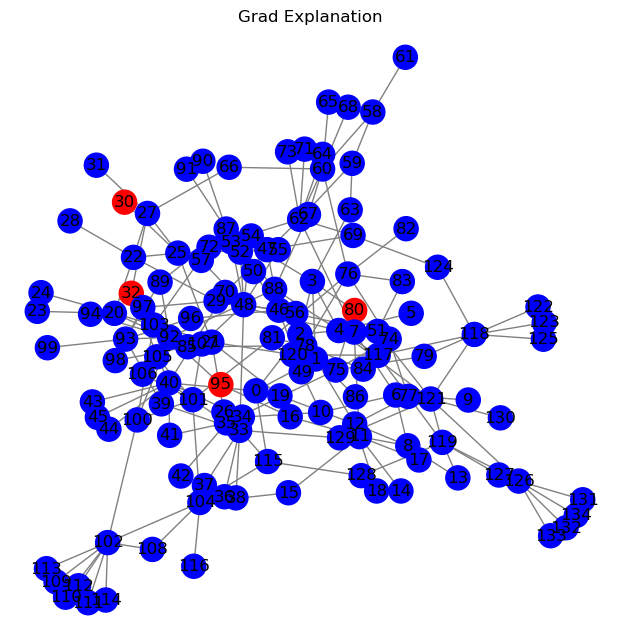

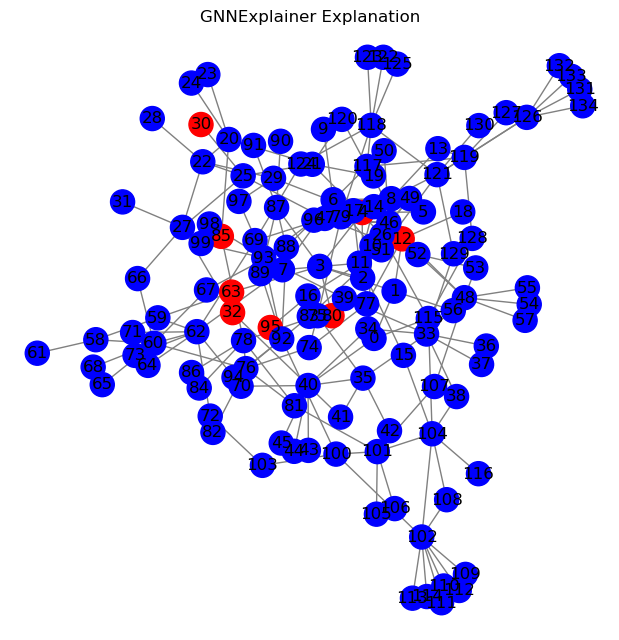

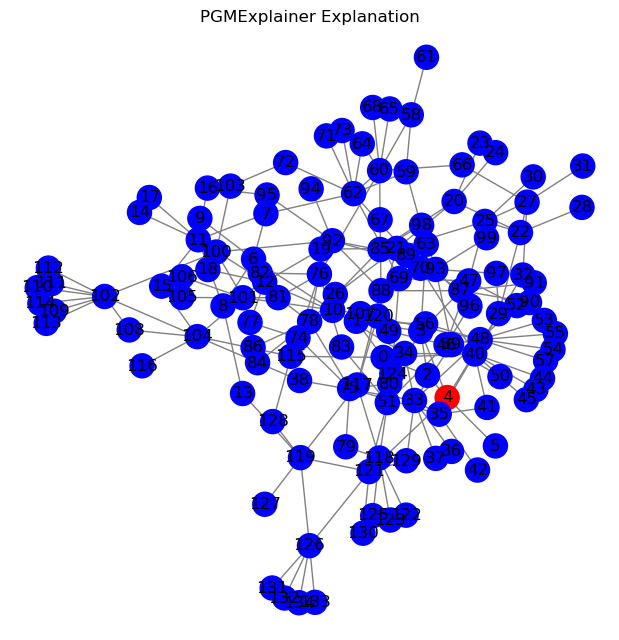

In [33]:
def visualize_explanation(graph, node_idx, explanation, title):
    plt.figure(figsize=(6, 6))
    G = nx.Graph()
    edges = graph.edge_index.cpu().numpy()
    for i in range(edges.shape[1]):
        G.add_edge(edges[0, i], edges[1, i])

    # Create a default color list for all nodes (blue)
    num_nodes = graph.x.size(0)
    node_colors = ['blue'] * num_nodes
    
    # Update colors based on node importance scores
    for node, imp in explanation.node_reference.items():
        if imp < len(explanation.node_imp):
            node_colors[node] = 'red' if explanation.node_imp[imp] > 0 else 'blue'

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=300, edge_color="gray")
    plt.title(title)
    plt.show()


# Visualisasi hasil explainability
visualize_explanation(data, node_idx, grad_explanation, "Grad Explanation")
visualize_explanation(data, node_idx, gnn_explanation, "GNNExplainer Explanation")
visualize_explanation(data, node_idx, pgm_explanation, "PGMExplainer Explanation")

In [34]:
# Try different hyperparameters for each explainer
grad_explainer = GradExplainer(model, criterion=F.nll_loss)

gnn_explainer = GNNExplainer(
    model,
)

pgm_explainer = PGMExplainer(
    model,
    explain_graph=False,
    num_samples=100,   # More samples for better probability estimation
    perturb_mode='mean'  # How to perturb features
)

# Function to compare explanations
def compare_explanations(node_idx, data, explainers, names):
    explanations = []
    for explainer in explainers:
        exp = explainer.get_explanation_node(
            node_idx=node_idx,
            x=data.x,
            edge_index=data.edge_index
        )
        explanations.append(exp)
    
    # Print importance scores
    for name, exp in zip(names, explanations):
        print(f"\n{name} top 5 important nodes:")
        imp_scores = [(i, score) for i, score in enumerate(exp.node_imp)]
        imp_scores.sort(key=lambda x: abs(x[1]), reverse=True)
        for node, score in imp_scores[:5]:
            print(f"Node {node}: {score:.4f}")

# Compare the explainers
explainers = [grad_explainer, gnn_explainer, pgm_explainer]
names = ['GradExplainer', 'GNNExplainer', 'PGMExplainer']
compare_explanations(node_idx, data, explainers, names)

  0%|          | 0/1000000 [00:00<?, ?it/s]


GradExplainer top 5 important nodes:
Node 9: 2.8094
Node 1: -2.3704
Node 2: -2.3704
Node 3: -2.3704
Node 8: 2.0103

GNNExplainer top 5 important nodes:
Node 0: 1.0000
Node 2: 1.0000
Node 4: 1.0000
Node 5: 1.0000
Node 6: 1.0000

PGMExplainer top 5 important nodes:
Node 1: 1.0000
Node 0: 0.0000
Node 2: 0.0000
Node 3: 0.0000
Node 4: 0.0000


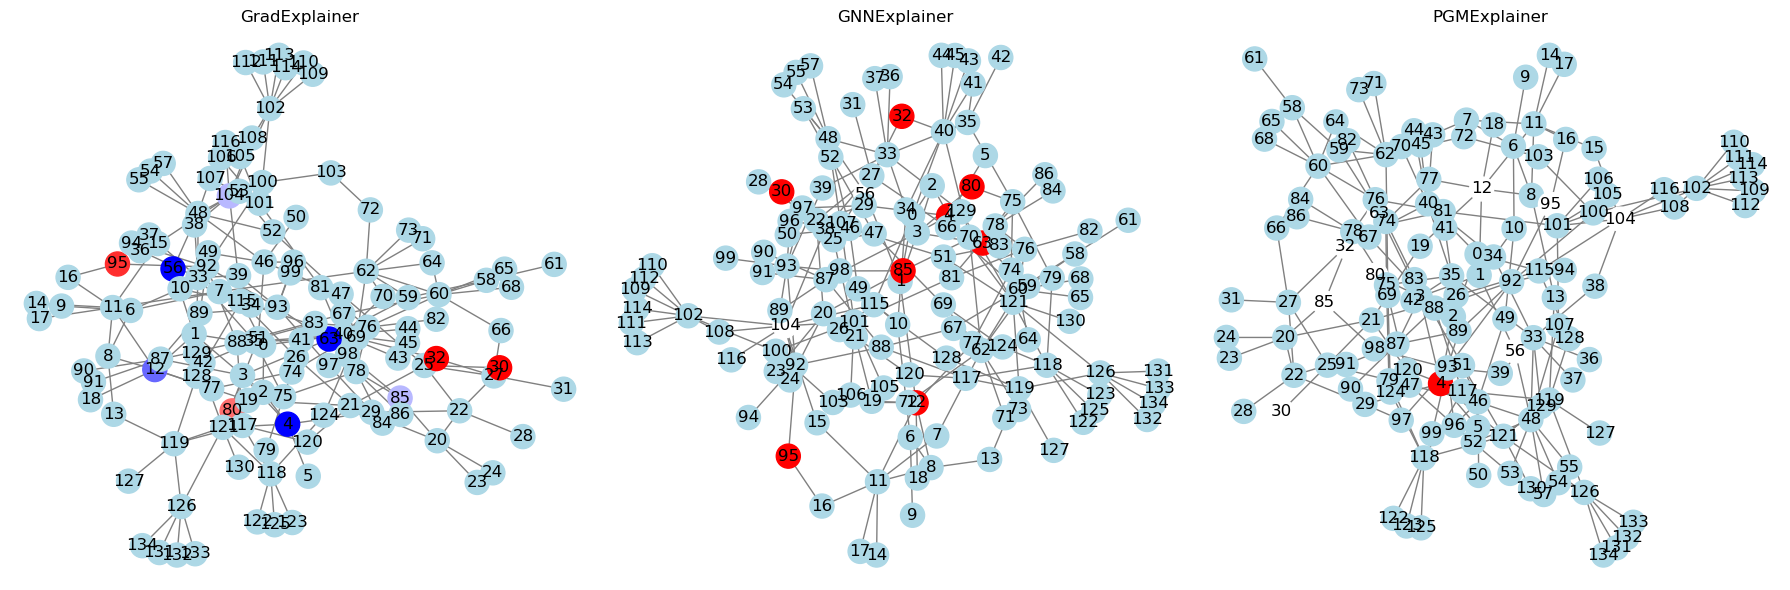

In [35]:
def plot_explanation_comparison(data, node_idx, explanations, titles):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for ax, exp, title in zip(axes, explanations, titles):
        G = nx.Graph()
        edges = data.edge_index.cpu().numpy()
        for i in range(edges.shape[1]):
            G.add_edge(edges[0, i], edges[1, i])
        
        # Create color map
        num_nodes = data.x.size(0)
        node_colors = ['lightblue'] * num_nodes  # default color
        
        # Map importance scores to colors
        for node, imp in exp.node_reference.items():
            if imp < len(exp.node_imp):
                # Convert PyTorch tensor to float
                score = float(exp.node_imp[imp].cpu())
                # Use red for positive importance, blue for negative
                if score > 0:
                    intensity = min(1.0, abs(score))
                    node_colors[node] = f'#{int(255):02x}{int(255*(1-intensity)):02x}{int(255*(1-intensity)):02x}'
                else:
                    intensity = min(1.0, abs(score))
                    node_colors[node] = f'#{int(255*(1-intensity)):02x}{int(255*(1-intensity)):02x}{int(255):02x}'
        
        pos = nx.spring_layout(G)
        nx.draw(G, pos, ax=ax, 
                with_labels=True, 
                node_color=node_colors, 
                node_size=300,
                edge_color="gray")
        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

# Get explanations and visualize
explanations = [grad_explanation, gnn_explanation, pgm_explanation]
titles = ['GradExplainer', 'GNNExplainer', 'PGMExplainer']
plot_explanation_comparison(data, node_idx, explanations, titles)